<a href="https://colab.research.google.com/github/ea-Mitsuoka/ionicons/blob/master/bqml_arima_ga360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
```
Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
```
---

# 概要
このチュートリアルでは、GA360_test.ga_sessions_sample サンプル テーブルを使用して時系列モデルを作成し、1 つの時系列予測を行う方法について説明します。

ga_sessions_sample テーブルには、Google アナリティクス 360 によって収集され、BigQuery に送信されたセッション データのスライスに関する情報が含まれています。

### 費用

このチュートリアルでは、Google BigQuery および BigQuery ML を使います。金額について詳細は  [BigQuery ML pricing](https://cloud.google.com/bigquery-ml/pricing) [Pricing
Calculator](https://cloud.google.com/products/calculator/)
を参照ください。

### 事前準備

**このノートブックを実行するには事前に次の手順が必要です。**

1. [GCP プロジェクトの作成もしくは選択](https://console.cloud.google.com/cloud-resource-manager). 最初にアカウントを作成すると、300ドルの無料クレジットが付与されます。

2. [課金設定を有効にします](https://cloud.google.com/billing/docs/how-to/modify-project)

3.   [BigQuery API](https://console.cloud.google.com/flows/enableapi?apiid=bigquery) を有効にします。

4. 下のセルを実行し、Google アカウントでログインして表示されるキーをセルに入力します。

5. 「プロジェクト変数の設定」のセルにご自身のプロジェクトIDを入力してください。

In [ ]:
import pandas as pd
import numpy as np
import sys
from google.cloud import bigquery
from google.colab import auth
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
auth.authenticate_user()

In [ ]:
#@title プロジェクト変数の設定 { run: "auto", display-mode: "form" }
project_id = '' #@param {type:"string"}
#dataset_name = "ga" #@param {type:"string"}
client = bigquery.Client(project=project_id)

まず、モデルを保存するためのデータセットが必要になります。 （エラーが発生した場合は、BigQueryコンソールから"iris"というデータセットを作成してください）。

In [ ]:
%%bash -s "$project_id"

gcloud config set project $1
bq --location=US mk -d bqml_tutorial

### 予測する時系列を可視化する
モデルを作成する前に、入力時系列がどのように表示されるかを確認しておきましょう。確認には Google データポータルを使用します。

次の標準 SQL クエリで、FROM bigquery-public-data.google_analytics_sample.ga_sessions_* 句は google_analytics_sample データセット内の ga_sessions_* テーブルをクエリしています。これらのテーブルはパーティション分割テーブルです。

SELECTステートメントで、入力テーブルの date 列を TIMESTAMP 型として解析し、名前を parsed_date に変更します。このクエリでは、SUM(...) 句と GROUP BY date 句を使用して、totals.visits を毎日集計します。

In [ ]:
query = '''
#standardSQL
SELECT
  PARSE_TIMESTAMP("%Y%m%d", date) AS parsed_date,
  SUM(totals.visits) AS total_visits
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY date
ORDER BY date
'''
df = client.query(query).to_dataframe()

In [ ]:
df.head()

,parsed_date,total_visits
0,2016-08-01 00:00:00+00:00,1711
1,2016-08-02 00:00:00+00:00,2140
2,2016-08-03 00:00:00+00:00,2890
3,2016-08-04 00:00:00+00:00,3161
4,2016-08-05 00:00:00+00:00,2702


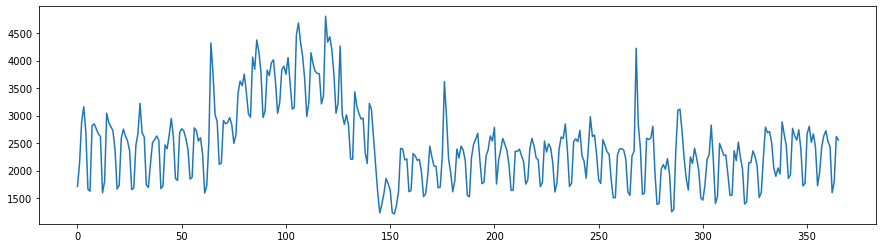

In [ ]:
df["total_visits"].plot(figsize=(15,4))

###  時系列モデルを作成する
次に、Google アナリティクス 360 のデータを使用して時系列モデルを作成します。次の標準 SQL クエリで、totals.visits の予測に使用するモデルを作成します。

CREATE MODEL 句で bqml_tutorial.ga_arima_model という名前のモデルを作成してトレーニングします。

OPTIONS(model_type='ARIMA', time_series_timestamp_col='date', ...) 句で ARIMA ベースの時系列モデルを作成しています。デフォルトは auto_arima=TRUE であるため、auto.ARIMA アルゴリズムによって ARIMA モデルのハイパーパラメータが自動的に調整されます。アルゴリズムが多数の候補モデルを学習し、AIC が最も低い最適なモデルを選択します。また、data_frequency='AUTO_FREQUENCY' がデフォルトのため、トレーニング プロセスでは入力時系列のデータ頻度が自動的に推定されます。

In [ ]:
query = '''
#standardSQL
CREATE OR REPLACE MODEL bqml_tutorial.ga_arima_model
OPTIONS
  (model_type = 'ARIMA',
   time_series_timestamp_col = 'parsed_date',
   time_series_data_col = 'total_visits'
  ) AS
SELECT
  PARSE_TIMESTAMP("%Y%m%d", date) AS parsed_date,
  SUM(totals.visits) AS total_visits
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY date
'''
client.query(query)

### 評価されたすべてのモデルの評価指標を調べる
モデルを作成した後、ML.EVALUATE 関数を使用すると、ハイパーパラメータの自動調整中に評価されたすべての候補モデルの評価指標を確認できます。

次の標準 SQL クエリの FROM 句では、モデル bqml_tutorial.ga_arima_model に ML.EVALUATE 関数を使用しています。評価指標はトレーニングの入力にのみ依存します。このため、モデルは ML.EVALUATE 関数への唯一の入力となります。

In [ ]:
query = """
#standardSQL
SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_tutorial.ga_arima_model`)
  """
df = client.query(query).to_dataframe()
df

結果には次の列が含まれます。

* non_seasonal_p
* non_seasonal_d
* non_seasonal_q
* has_drift
* log_likelihood
* AIC
* variance
* seasonal_periods
次の 4 つの列（non_seasonal_{p,d,q} と has_drift）で ARIMA モデルを定義します。その後の 3 つの指標（log_likelihood、AIC、variance）は ARIMA モデルの適合プロセスに関連しています。

まず、auto.ARIMA アルゴリズムは KPSS テストを使用して、non_seasonal_d の最適値を 1 に決定します。non_seasonal_d が 1 の場合、auto.ARIMA は 42 個の ARIMA 候補モデルを並行してトレーニングします。non_seasonal_dが 1 でない場合、auto.ARIMA は 21 の異なる候補モデルをトレーニングします。この例では、42 個の候補モデルがすべて有効です。したがって、出力には 42 行が含まれ、各行は ARIMA 候補モデルに関連付けられています。一部の時系列では、非反転または非静止の候補モデルが無効になります。無効なモデルは出力から除外されるため、出力行数は 42 行未満になります。これらの候補モデルは AIC の昇順で並べ替えられます。最初の行のモデルは AIC が最も低く、最適なモデルとみなされます。この最適モデルが最終モデルとして保存され、次に示すように ML.FORECAST と ML.ARIMA_COEFFICIENTS を呼び出すときに使用されます。

seasonal_periods は、入力時系列の季節性パターンに関するものです。ARIMA モデリングとは関係がないため、すべての出力行で同じ値になります。上記のステップ 2 で説明したように、1 週間のパターンが報告されますが、これは想定内です。

###  モデルの係数を調べる
ML.ARIMA_COEFFICIENTS 関数は、ARIMA モデル bqml_tutorial.ga_arima_model のモデル係数を取得します。ML.ARIMA_COEFFICIENTS は、モデルを唯一の入力として受け取ります。

In [ ]:
query = """
#standardSQL
SELECT
  *
FROM
  ML.ARIMA_COEFFICIENTS(MODEL bqml_tutorial.ga_arima_model)
  """
df = client.query(query).to_dataframe()
df

,ar_coefficients,ma_coefficients,intercept_or_drift
0,"[-0.20248098870729564, -0.6596890300060043]","[-0.1620980631713405, 0.7066274129311112, -0.6...",4.101492


結果には次の列が含まれます。

* ar_coefficients
* ma_coefficients
* intercept_or_drift

ar_coefficients は、ARIMA モデルの自己回帰（AR）部分のモデル係数を示します。同様に、ma_coefficients は移動平均（MA）部分のモデル係数を示します。どちらも配列で、長さはそれぞれ non_seasonal_p と non_seasonal_q です。ML.EVALUATE の出力から、一番上の行の non_seasonal_p は 2 で、non_seasonal_q は 3 です。したがって、ar_coefficients は長さ 2 の配列で、ma_coefficients は長さ 3 の配列です。intercept_or_drift は、ARIMA モデルの定数項です。

### モデルを使用して時系列を予測する
ML.FORECAST 関数は、モデル bqml_tutorial.ga_arima_model を使用して予測間隔で将来の時系列値を予測します。

次の標準 SQL クエリでは、STRUCT(30 AS horizon, 0.8 AS confidence_level) 句は 30 個の将来の時点を予測し、信頼度 80% の予測間隔を生成します。ML.FORECAST は、モデルとオプションの引数を受け取ります。

In [ ]:
query = """
#standardSQL
SELECT
  *
FROM
  ML.FORECAST(MODEL bqml_tutorial.ga_arima_model,
              STRUCT(30 AS horizon, 0.8 AS confidence_level))
  """
df = client.query(query).to_dataframe()
df

結果には次の列が含まれます。

* forecast_timestamp
* forecast_value
* standard_error
* confidence_level
* prediction_interval_lower_bound
* prediction_interval_upper_bound
* confidence_interval_lower_bound（間もなくサポート終了）
* confidence_interval_upper_bound（間もなくサポート終了）

出力行は forecast_timestamp の日付順に表示されます。時系列予測の場合、下限と上限で取得される予測間隔は forecast_value と同じくらい重要です。forecast_value は予測間隔の中間点です。予測間隔は standard_error と confidence_level によって異なります。

### ステップ 7: 予測結果を可視化する
時系列の予測結果をすぐに評価できるようにするには、予測時系列と履歴時系列を可視化します。次のクエリに示すように、履歴時系列と予測時系列を連結します。

UNION ALL 句の前の SQL で履歴時系列を作成します。UNION ALL 句の後の SQL で、ML.FORECAST を使用して予測時系列と予測間隔を生成します。このクエリでは、history_value と forecasted_value に異なるフィールドを使用して、それぞれを異なる色で表示しています。

In [ ]:
query = """
#standardSQL
SELECT
  history_timestamp AS timestamp,
  history_value,
  NULL AS forecast_value,
  NULL AS prediction_interval_lower_bound,
  NULL AS prediction_interval_upper_bound
FROM
  (
    SELECT
      PARSE_TIMESTAMP("%Y%m%d", date) AS history_timestamp,
      SUM(totals.visits) AS history_value
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    GROUP BY date
    ORDER BY date ASC
  )
UNION ALL
SELECT
  forecast_timestamp AS timestamp,
  NULL AS history_value,
  forecast_value,
  prediction_interval_lower_bound,
  prediction_interval_upper_bound
FROM
  ML.FORECAST(MODEL bqml_tutorial.ga_arima_model,
              STRUCT(30 AS horizon, 0.8 AS confidence_level))
              ORDER BY 1 ASC
  """
df = client.query(query).to_dataframe()

df

,timestamp,history_value,forecast_value,prediction_interval_lower_bound,prediction_interval_upper_bound
0,2016-08-01 00:00:00+00:00,1711.0,NaN,NaN,NaN
1,2016-08-02 00:00:00+00:00,2140.0,NaN,NaN,NaN
2,2016-08-03 00:00:00+00:00,2890.0,NaN,NaN,NaN
3,2016-08-04 00:00:00+00:00,3161.0,NaN,NaN,NaN
4,2016-08-05 00:00:00+00:00,2702.0,NaN,NaN,NaN
...,...,...,...,...,...
391,2017-08-27 00:00:00+00:00,NaN,1968.176040,1303.523548,2632.828532
392,2017-08-28 00:00:00+00:00,NaN,2632.702422,1957.431982,3307.972863
393,2017-08-29 00:00:00+00:00,NaN,2671.103680,1985.264787,3356.942573
394,2017-08-30 00:00:00+00:00,NaN,2758.018631,2061.759814,3454.277449


In [ ]:
df2=df.loc[:,['history_value','forecast_value','prediction_interval_lower_bound','prediction_interval_upper_bound']]

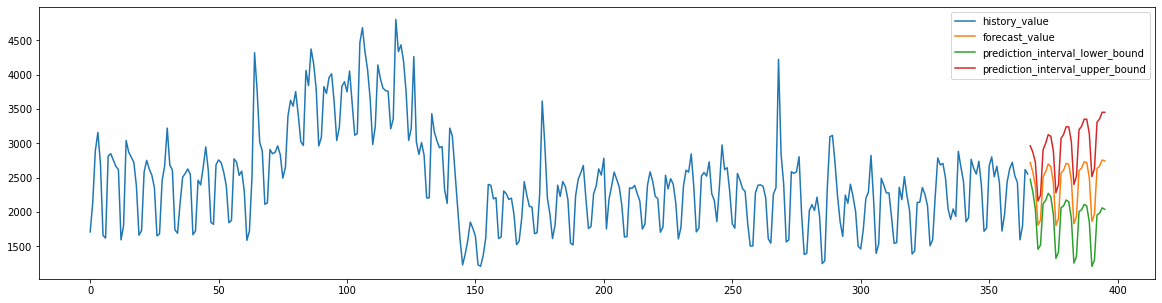

In [ ]:
df2.plot(figsize=(20,5))

### クリーンアップ
すべての作業が完了したら、以下のURLを参考に、プロジェクトを必要に応じてクリーンアップしてください。
https://cloud.google.com/go/getting-started/delete-tutorial-resources?hl=ja